In [1]:
import os
import sys
import csv
import pandas as pd
import numpy as np

import os.path
from os import path

import PIL
from PIL import Image

import cv2
import glob
import h5py
import os
import pathlib
import tables

import torch
from skimage import io, transform
from sklearn import metrics
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from matplotlib import pyplot

import torch
import timm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.functional import kl_div, softmax, log_softmax
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

/home/irene/myenv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hdf5_path = '/home/irene/ISEF-Project-2023/HDF5.hdf5'
file = h5py.File(hdf5_path, "r")
file.keys()

<KeysViewHDF5 ['test_img', 'test_label', 'test_path', 'train_img', 'train_label', 'train_path', 'val_img', 'val_label', 'val_path']>

In [3]:
rgb_mean,rgb_std = (0.485, 0.456, 0.406),(0.229, 0.224, 0.225)

In [9]:
from torch.utils.data import Dataset,DataLoader

train_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="train"), batch_size=8,shuffle=True,drop_last=False)
val_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="val"), batch_size=8,shuffle=True,drop_last=False)
test_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="test"), batch_size=8,shuffle=True,drop_last=False)

In [4]:
class HDF5Dataset(Dataset):


    def __init__(self, h5_path, set_name, transform = None):
        self.h5_path = h5_path
        self.dataset = None
        self.transform = transform
        self.file_path  = h5_path
        self.set = set_name
        
        str_name = self.set + "_img"
        
        file = h5py.File(h5_path, "r")
        self.dataset_len = len(file[str_name])
        
        self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(rgb_mean,rgb_std)
            ])
        
    def __getitem__(self, index): #to enable indexing
        
        if self.dataset is None:
            self.imgs = h5py.File(self.file_path, 'r')[self.set + "_img"]
            self.labels = h5py.File(self.file_path, 'r')[self.set + "_label"]
            
            cur_img = self.imgs[index]
            PIL_image = Image.fromarray(np.uint8(cur_img)).convert('RGB')#3 channels don't need alpha channel network input
            image = self.transform(PIL_image)
            label = self.labels[index].astype('float32')
            
            
        return (image,label)

    def __len__(self):
        return self.dataset_len

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

out_dim = 2

model = timm.create_model("vgg16", pretrained=True)
model.head.fc = nn.Linear(model.head.fc.in_features, out_dim)

model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,weight_decay = 1e-4,momentum = 0.9)
criterion = nn.CrossEntropyLoss()



#epoch 20 --> epoch 100 or 50 see what happens
def train_valid_model (net,loaders,max_epochs = 20):
    best_acc = 0.0 
    for epoch in range (max_epochs):
        for phase in ['train','val']:
            iterator = iter(loaders[phase])
            total_step = len(loaders[phase])
            print('Phase {}'.format(phase))
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            running_loss = 0.0
            running_correct = 0
            
            predictions_all = []
            label_all = []
            probs_all = []
            for step in range(total_step-1): #iterate each batch
                images,labels = next(iterator) # CUDA computation
                images = images.to(device)
                labels = labels.to(device)
                labels = labels.long()
                optimizer.zero_grad()
                
                output = net(images)
                loss = criterion(output,labels)
                
                probs = torch.nn.functional.softmax(output, dim=1) # probabilities
                
                running_loss +=loss.item()
                _, preds = torch.max(output.data,1)
                
                running_correct += (preds == labels).sum().item()
                
                if len(predictions_all) == 0:
                    predictions_all = preds.detach().cpu().numpy()
                    label_all = labels.detach().cpu().numpy()
                    probs_all = probs.detach().cpu().numpy()
                else:
                    predictions_all = np.vstack((predictions_all, preds.detach().cpu().numpy()))
                    probs_all = np.vstack((probs_all, probs.detach().cpu().numpy()))
                    label_all = np.vstack((label_all, labels.detach().cpu().numpy()))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
                    
            phase_loss = running_loss / len(loaders[phase])
            phase_acc = running_correct/len(label_all.flatten())
            if phase == 'val':
                y_true = label_all.flatten()
                y_pred = predictions_all.flatten()
                print("validating...")
                print(len(y_true))
                print(len(y_pred))
                print(metrics.classification_report(y_true, y_pred, digits=3))
            if phase == 'val' and phase_acc > best_acc:
                
                best_acc = phase_acc
                import copy 
                
                best_model_state_dict = copy.deepcopy(net.state_dict())
                torch.save(best_model_state_dict,'vgg16best_model.pth')
                
            print('PHASE {} Loss: {:.4f} Acc: {:.4f}'.format(phase, phase_loss, phase_acc))
    net.load_state_dict(best_model_state_dict)
    
    return net 
            
       
print(device)  

cuda


In [7]:
def test_best_model (net, test_loader, a_device = None):
    iterator = iter(test_loader)
    total_step = len(test_loader)
    
    print(total_step)
    net.eval()
    
    with torch.no_grad():
        running_loss = 0
        running_corrects = 0
        
        total_0,total_1 = 0,0
        hit_0 = 0
        hit_1 = 0
        label_all = []
        probs_all = []
        predictions_all = []
        for step in range(total_step-1):
            images,labels = next(iterator)
            images.to(a_device)
            labels.to(a_device)
            total_0 += labels.tolist().count(0)
            total_1 += labels.tolist().count(1)
            print(labels.shape)
            images = images.to(a_device)
            labels = labels.to(device=a_device, dtype=torch.int64)
            labels = labels.long()
            
            output = net(images)
            loss = criterion(output,labels)
            
            probs = torch.nn.functional.softmax(output, dim=1)

            running_loss +=loss.item()
            _, preds = torch.max(output.data,1)
            
            equals = preds == labels.view(*preds.shape)
            if(len(label_all) ==0):
                predictions_all = preds.detach().cpu().numpy()
                label_all = labels.detach().cpu().numpy()
                probs_all = probs.detach().cpu().numpy()
            else:
                predictions_all = np.vstack((predictions_all, preds.detach().cpu().numpy()))
                label_all = np.vstack((label_all, labels.detach().cpu().numpy()))
                probs_all = np.vstack((probs_all, probs.detach().cpu().numpy()))

            all_hits = equals.view(equals.shape[0]).tolist() 
            all_corrects = labels[all_hits]
            
            hit_0 += all_corrects.tolist().count(0)
            hit_1 += all_corrects.tolist().count(1)
 
        
            running_corrects += (preds == labels).sum().item()
        print(len(label_all.flatten()))
        label_all = label_all.flatten()
        predictions_all = predictions_all.flatten()
        phase_loss = running_loss / len(test_loader)
        phase_acc = running_corrects/len(label_all.flatten())
        print('Test Loss: {:.4f} Acc: {:.4f}'.format(phase_loss, phase_acc))
        
        print(hit_0, ' / ',total_0)
        print(hit_1, ' / ',total_1)
                
            
    return label_all, probs_all, predictions_all #add this later
                
        #y_test --> label, y_score --> probs all 

In [10]:
epochs = 100
loaders = dict({'train': train_loader, 'val': val_loader})
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------")
    bestmodel = train_valid_model (model,loaders)
    

Epoch 1
-----------------------
Phase train
PHASE train Loss: 0.5665 Acc: 0.6750
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.851     0.610     0.711       159
           1      0.699     0.894     0.785       161

    accuracy                          0.753       320
   macro avg      0.775     0.752     0.748       320
weighted avg      0.774     0.753     0.748       320

PHASE val Loss: 0.5718 Acc: 0.7531
Phase train
PHASE train Loss: 0.4871 Acc: 0.7792
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.850     0.576     0.687       158
           1      0.685     0.901     0.779       162

    accuracy                          0.741       320
   macro avg      0.768     0.739     0.733       320
weighted avg      0.767     0.741     0.733       320

PHASE val Loss: 0.4580 Acc: 0.7406
Phase train
PHASE train Loss: 0.4074 Acc: 0.8187
Phase val
validating...
320
320
 

PHASE train Loss: 0.0411 Acc: 0.9865
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.795     0.830     0.812       159
           1      0.825     0.789     0.806       161

    accuracy                          0.809       320
   macro avg      0.810     0.810     0.809       320
weighted avg      0.810     0.809     0.809       320

PHASE val Loss: 0.6773 Acc: 0.8094
Epoch 2
-----------------------
Phase train
PHASE train Loss: 0.0973 Acc: 0.9604
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.843     0.711     0.771       159
           1      0.753     0.870     0.807       161

    accuracy                          0.791       320
   macro avg      0.798     0.790     0.789       320
weighted avg      0.798     0.791     0.789       320

PHASE val Loss: 0.6246 Acc: 0.7906
Phase train
PHASE train Loss: 0.1047 Acc: 0.9635
Phase val
validating...
320
320
             

PHASE train Loss: 0.0098 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.815     0.810     0.813       158
           1      0.816     0.821     0.818       162

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 0.8906 Acc: 0.8156
Phase train
PHASE train Loss: 0.0092 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.833     0.823     0.828       158
           1      0.829     0.840     0.834       162

    accuracy                          0.831       320
   macro avg      0.831     0.831     0.831       320
weighted avg      0.831     0.831     0.831       320

PHASE val Loss: 0.8364 Acc: 0.8313
Epoch 3
-----------------------
Phase train
PHASE train Loss: 0.0098 Acc: 0.9938
Phase val
validating...
320
320
             

PHASE train Loss: 0.0080 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.785     0.805     0.795       159
           1      0.803     0.783     0.792       161

    accuracy                          0.794       320
   macro avg      0.794     0.794     0.794       320
weighted avg      0.794     0.794     0.794       320

PHASE val Loss: 1.0264 Acc: 0.7937
Phase train
PHASE train Loss: 0.0070 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.788     0.778     0.783       158
           1      0.787     0.796     0.791       162

    accuracy                          0.787       320
   macro avg      0.788     0.787     0.787       320
weighted avg      0.788     0.787     0.787       320

PHASE val Loss: 1.0357 Acc: 0.7875
Phase train
PHASE train Loss: 0.0080 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0064 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.808     0.797     0.803       158
           1      0.805     0.815     0.810       162

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 0.9553 Acc: 0.8063
Phase train
PHASE train Loss: 0.0099 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.801     0.811     0.806       159
           1      0.811     0.801     0.806       161

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 0.9504 Acc: 0.8063
Phase train
PHASE train Loss: 0.0070 Acc: 0.9979
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0075 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.800     0.810     0.805       158
           1      0.812     0.802     0.807       162

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 1.0100 Acc: 0.8063
Phase train
PHASE train Loss: 0.0094 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.804     0.824     0.814       159
           1      0.822     0.801     0.811       161

    accuracy                          0.812       320
   macro avg      0.813     0.813     0.812       320
weighted avg      0.813     0.812     0.812       320

PHASE val Loss: 0.9168 Acc: 0.8125
Phase train
PHASE train Loss: 0.0079 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0074 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.804     0.804     0.804       158
           1      0.809     0.809     0.809       162

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 1.0061 Acc: 0.8063
Phase train
PHASE train Loss: 0.0069 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.809     0.804     0.806       158
           1      0.810     0.815     0.812       162

    accuracy                          0.809       320
   macro avg      0.809     0.809     0.809       320
weighted avg      0.809     0.809     0.809       320

PHASE val Loss: 0.9707 Acc: 0.8094
Phase train
PHASE train Loss: 0.0080 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0074 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.797     0.797     0.797       158
           1      0.802     0.802     0.802       162

    accuracy                          0.800       320
   macro avg      0.800     0.800     0.800       320
weighted avg      0.800     0.800     0.800       320

PHASE val Loss: 1.0117 Acc: 0.8000
Phase train
PHASE train Loss: 0.0075 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.812     0.818     0.815       159
           1      0.819     0.814     0.816       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 0.9970 Acc: 0.8156
Phase train
PHASE train Loss: 0.0074 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0079 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.789     0.804     0.796       158
           1      0.805     0.790     0.798       162

    accuracy                          0.797       320
   macro avg      0.797     0.797     0.797       320
weighted avg      0.797     0.797     0.797       320

PHASE val Loss: 1.1039 Acc: 0.7969
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.805     0.805     0.805       159
           1      0.807     0.807     0.807       161

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 1.0394 Acc: 0.8063
Phase train
PHASE train Loss: 0.0071 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE val Loss: 0.9137 Acc: 0.8313
Phase train
PHASE train Loss: 0.0073 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.824     0.824     0.824       159
           1      0.826     0.826     0.826       161

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 1.0199 Acc: 0.8250
Phase train
PHASE train Loss: 0.0075 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.830     0.830     0.830       159
           1      0.832     0.832     0.832       161

    accuracy                          0.831       320
   macro avg      0.831     0.831     0.831       320
weighted avg      0.831     0.831     0.831       320

PHASE val Loss: 0.9568 Acc: 0.8313
Phase train
PHASE train Loss: 0.0074 Acc: 0.9927
Phase val
validating...
320
32

PHASE train Loss: 0.0073 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.812     0.818     0.815       159
           1      0.819     0.814     0.816       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0142 Acc: 0.8156
Phase train
PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.829     0.829     0.829       158
           1      0.833     0.833     0.833       162

    accuracy                          0.831       320
   macro avg      0.831     0.831     0.831       320
weighted avg      0.831     0.831     0.831       320

PHASE val Loss: 0.9715 Acc: 0.8313
Phase train
PHASE train Loss: 0.0074 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0076 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.810     0.830     0.820       159
           1      0.828     0.807     0.818       161

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0226 Acc: 0.8187
Phase train
PHASE train Loss: 0.0074 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.816     0.811     0.814       159
           1      0.815     0.820     0.817       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0597 Acc: 0.8156
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0075 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.807     0.823     0.815       158
           1      0.824     0.809     0.816       162

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0825 Acc: 0.8156
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.814     0.829     0.821       158
           1      0.830     0.815     0.822       162

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 0.9936 Acc: 0.8219
Phase train
PHASE train Loss: 0.0071 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0069 Acc: 0.9979
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.818     0.818     0.818       159
           1      0.820     0.820     0.820       161

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.1165 Acc: 0.8187
Phase train
PHASE train Loss: 0.0078 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.839     0.823     0.831       158
           1      0.830     0.846     0.838       162

    accuracy                          0.834       320
   macro avg      0.835     0.834     0.834       320
weighted avg      0.834     0.834     0.834       320

PHASE val Loss: 1.0179 Acc: 0.8344
Phase train
PHASE train Loss: 0.0075 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0072 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.814     0.824     0.819       159
           1      0.824     0.814     0.819       161

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 0.9973 Acc: 0.8187
Phase train
PHASE train Loss: 0.0074 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.801     0.811     0.806       159
           1      0.811     0.801     0.806       161

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 1.1112 Acc: 0.8063
Phase train
PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0079 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.801     0.791     0.796       158
           1      0.799     0.809     0.804       162

    accuracy                          0.800       320
   macro avg      0.800     0.800     0.800       320
weighted avg      0.800     0.800     0.800       320

PHASE val Loss: 1.0739 Acc: 0.8000
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.812     0.818     0.815       159
           1      0.819     0.814     0.816       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0372 Acc: 0.8156
Phase train
PHASE train Loss: 0.0071 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE val Loss: 1.0513 Acc: 0.8219
Phase train
PHASE train Loss: 0.0068 Acc: 0.9979
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.833     0.818     0.825       159
           1      0.823     0.839     0.831       161

    accuracy                          0.828       320
   macro avg      0.828     0.828     0.828       320
weighted avg      0.828     0.828     0.828       320

PHASE val Loss: 0.9955 Acc: 0.8281
Phase train
PHASE train Loss: 0.0068 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.818     0.818     0.818       159
           1      0.820     0.820     0.820       161

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0381 Acc: 0.8187
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
32

PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.818     0.818     0.818       159
           1      0.820     0.820     0.820       161

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 0.9949 Acc: 0.8187
Phase train
PHASE train Loss: 0.0074 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.809     0.824     0.816       159
           1      0.823     0.807     0.815       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0324 Acc: 0.8156
Phase train
PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE val Loss: 1.0260 Acc: 0.8281
Phase train
PHASE train Loss: 0.0076 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.792     0.797     0.795       158
           1      0.801     0.796     0.799       162

    accuracy                          0.797       320
   macro avg      0.797     0.797     0.797       320
weighted avg      0.797     0.797     0.797       320

PHASE val Loss: 1.1119 Acc: 0.7969
Phase train
PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.814     0.804     0.809       158
           1      0.811     0.821     0.816       162

    accuracy                          0.812       320
   macro avg      0.813     0.812     0.812       320
weighted avg      0.813     0.812     0.812       320

PHASE val Loss: 0.9950 Acc: 0.8125
Phase train
PHASE train Loss: 0.0069 Acc: 0.9958
Phase val
validating...
320
32

PHASE val Loss: 1.0747 Acc: 0.8250
Phase train
PHASE train Loss: 0.0074 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.806     0.816     0.811       158
           1      0.819     0.809     0.814       162

    accuracy                          0.812       320
   macro avg      0.812     0.813     0.812       320
weighted avg      0.813     0.812     0.813       320

PHASE val Loss: 1.0893 Acc: 0.8125
Phase train
PHASE train Loss: 0.0080 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.816     0.836     0.826       159
           1      0.834     0.814     0.824       161

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 1.0388 Acc: 0.8250
Phase train
PHASE train Loss: 0.0069 Acc: 0.9958
Phase val
validating...
320
32

PHASE train Loss: 0.0074 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.815     0.805     0.810       159
           1      0.810     0.820     0.815       161

    accuracy                          0.812       320
   macro avg      0.813     0.812     0.812       320
weighted avg      0.813     0.812     0.812       320

PHASE val Loss: 1.0611 Acc: 0.8125
Phase train
PHASE train Loss: 0.0069 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.809     0.799     0.804       159
           1      0.804     0.814     0.809       161

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 1.1609 Acc: 0.8063
Phase train
PHASE train Loss: 0.0067 Acc: 0.9979
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0074 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.815     0.810     0.813       158
           1      0.816     0.821     0.818       162

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0901 Acc: 0.8156
Epoch 21
-----------------------
Phase train
PHASE train Loss: 0.0069 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.828     0.823     0.825       158
           1      0.828     0.833     0.831       162

    accuracy                          0.828       320
   macro avg      0.828     0.828     0.828       320
weighted avg      0.828     0.828     0.828       320

PHASE val Loss: 1.0710 Acc: 0.8281
Phase train
PHASE train Loss: 0.0080 Acc: 0.9917
Phase val
validating...
320
320
            

PHASE train Loss: 0.0074 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.827     0.811     0.819       159
           1      0.817     0.832     0.825       161

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 1.0956 Acc: 0.8219
Phase train
PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.812     0.823     0.818       158
           1      0.825     0.815     0.820       162

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0402 Acc: 0.8187
Epoch 22
-----------------------
Phase train
PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
            

PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.801     0.811     0.806       159
           1      0.811     0.801     0.806       161

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 1.0925 Acc: 0.8063
Phase train
PHASE train Loss: 0.0075 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.820     0.830     0.825       159
           1      0.830     0.820     0.825       161

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 1.0326 Acc: 0.8250
Phase train
PHASE train Loss: 0.0073 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0070 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.811     0.816     0.814       158
           1      0.820     0.815     0.817       162

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0051 Acc: 0.8156
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.819     0.824     0.821       159
           1      0.825     0.820     0.822       161

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 0.9608 Acc: 0.8219
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0075 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.809     0.804     0.806       158
           1      0.810     0.815     0.812       162

    accuracy                          0.809       320
   macro avg      0.809     0.809     0.809       320
weighted avg      0.809     0.809     0.809       320

PHASE val Loss: 1.0075 Acc: 0.8094
Phase train
PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.823     0.823     0.823       158
           1      0.827     0.827     0.827       162

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 0.9939 Acc: 0.8250
Phase train
PHASE train Loss: 0.0074 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.816     0.811     0.814       159
           1      0.815     0.820     0.817       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.1161 Acc: 0.8156
Phase train
PHASE train Loss: 0.0073 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.791     0.811     0.801       159
           1      0.809     0.789     0.799       161

    accuracy                          0.800       320
   macro avg      0.800     0.800     0.800       320
weighted avg      0.800     0.800     0.800       320

PHASE val Loss: 1.1430 Acc: 0.8000
Phase train
PHASE train Loss: 0.0073 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.819     0.804     0.812       158
           1      0.812     0.827     0.820       162

    accuracy                          0.816       320
   macro avg      0.816     0.815     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.1035 Acc: 0.8156
Phase train
PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.832     0.811     0.822       159
           1      0.818     0.839     0.828       161

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 1.1166 Acc: 0.8250
Phase train
PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.806     0.816     0.811       158
           1      0.819     0.809     0.814       162

    accuracy                          0.812       320
   macro avg      0.812     0.813     0.812       320
weighted avg      0.813     0.812     0.813       320

PHASE val Loss: 1.0687 Acc: 0.8125
Phase train
PHASE train Loss: 0.0073 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.807     0.818     0.813       159
           1      0.818     0.807     0.813       161

    accuracy                          0.812       320
   macro avg      0.813     0.813     0.813       320
weighted avg      0.813     0.812     0.813       320

PHASE val Loss: 1.0046 Acc: 0.8125
Phase train
PHASE train Loss: 0.0071 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.791     0.811     0.801       159
           1      0.809     0.789     0.799       161

    accuracy                          0.800       320
   macro avg      0.800     0.800     0.800       320
weighted avg      0.800     0.800     0.800       320

PHASE val Loss: 1.0607 Acc: 0.8000
Phase train
PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.823     0.818     0.820       159
           1      0.821     0.826     0.824       161

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 0.9900 Acc: 0.8219
Phase train
PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.820     0.835     0.828       158
           1      0.836     0.821     0.829       162

    accuracy                          0.828       320
   macro avg      0.828     0.828     0.828       320
weighted avg      0.828     0.828     0.828       320

PHASE val Loss: 1.0305 Acc: 0.8281
Phase train
PHASE train Loss: 0.0074 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.825     0.835     0.830       158
           1      0.838     0.827     0.832       162

    accuracy                          0.831       320
   macro avg      0.831     0.831     0.831       320
weighted avg      0.831     0.831     0.831       320

PHASE val Loss: 1.0035 Acc: 0.8313
Phase train
PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0065 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.812     0.818     0.815       159
           1      0.819     0.814     0.816       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.1254 Acc: 0.8156
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.816     0.816     0.816       158
           1      0.821     0.821     0.821       162

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0127 Acc: 0.8187
Phase train
PHASE train Loss: 0.0070 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0074 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.818     0.823     0.820       158
           1      0.826     0.821     0.824       162

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 1.0623 Acc: 0.8219
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.807     0.823     0.815       158
           1      0.824     0.809     0.816       162

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0542 Acc: 0.8156
Phase train
PHASE train Loss: 0.0075 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0071 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.799     0.829     0.814       158
           1      0.827     0.796     0.811       162

    accuracy                          0.812       320
   macro avg      0.813     0.813     0.812       320
weighted avg      0.813     0.812     0.812       320

PHASE val Loss: 1.0411 Acc: 0.8125
Phase train
PHASE train Loss: 0.0072 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.812     0.823     0.818       158
           1      0.825     0.815     0.820       162

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0675 Acc: 0.8187
Phase train
PHASE train Loss: 0.0073 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.824     0.824     0.824       159
           1      0.826     0.826     0.826       161

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 1.0817 Acc: 0.8250
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.821     0.810     0.815       158
           1      0.817     0.827     0.822       162

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0822 Acc: 0.8187
Phase train
PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0072 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.819     0.824     0.821       159
           1      0.825     0.820     0.822       161

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 1.0437 Acc: 0.8219
Phase train
PHASE train Loss: 0.0073 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.820     0.830     0.825       159
           1      0.830     0.820     0.825       161

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 1.0106 Acc: 0.8250
Phase train
PHASE train Loss: 0.0070 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.814     0.829     0.821       158
           1      0.830     0.815     0.822       162

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 1.0661 Acc: 0.8219
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.818     0.818     0.818       159
           1      0.820     0.820     0.820       161

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0106 Acc: 0.8187
Phase train
PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0070 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.820     0.830     0.825       159
           1      0.830     0.820     0.825       161

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 1.0015 Acc: 0.8250
Phase train
PHASE train Loss: 0.0073 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.815     0.810     0.813       158
           1      0.816     0.821     0.818       162

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0755 Acc: 0.8156
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE val Loss: 1.0586 Acc: 0.8156
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.804     0.804     0.804       158
           1      0.809     0.809     0.809       162

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 1.0642 Acc: 0.8063
Phase train
PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.828     0.823     0.825       158
           1      0.828     0.833     0.831       162

    accuracy                          0.828       320
   macro avg      0.828     0.828     0.828       320
weighted avg      0.828     0.828     0.828       320

PHASE val Loss: 1.0758 Acc: 0.8281
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
32

PHASE val Loss: 1.0580 Acc: 0.8094
Phase train
PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.826     0.810     0.818       158
           1      0.818     0.833     0.826       162

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 1.0291 Acc: 0.8219
Phase train
PHASE train Loss: 0.0071 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.806     0.836     0.821       159
           1      0.832     0.801     0.816       161

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0484 Acc: 0.8187
Phase train
PHASE train Loss: 0.0075 Acc: 0.9917
Phase val
validating...
320
32

PHASE train Loss: 0.0072 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.806     0.816     0.811       158
           1      0.819     0.809     0.814       162

    accuracy                          0.812       320
   macro avg      0.812     0.813     0.812       320
weighted avg      0.813     0.812     0.813       320

PHASE val Loss: 1.0625 Acc: 0.8125
Phase train
PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.806     0.816     0.811       158
           1      0.819     0.809     0.814       162

    accuracy                          0.812       320
   macro avg      0.812     0.813     0.812       320
weighted avg      0.813     0.812     0.813       320

PHASE val Loss: 1.0455 Acc: 0.8125
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.810     0.810     0.810       158
           1      0.815     0.815     0.815       162

    accuracy                          0.812       320
   macro avg      0.812     0.812     0.812       320
weighted avg      0.812     0.812     0.812       320

PHASE val Loss: 1.0398 Acc: 0.8125
Epoch 40
-----------------------
Phase train
PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.812     0.791     0.801       158
           1      0.801     0.821     0.811       162

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 1.0516 Acc: 0.8063
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
            

PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.806     0.811     0.809       159
           1      0.812     0.807     0.810       161

    accuracy                          0.809       320
   macro avg      0.809     0.809     0.809       320
weighted avg      0.809     0.809     0.809       320

PHASE val Loss: 1.1281 Acc: 0.8094
Phase train
PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.806     0.816     0.811       158
           1      0.819     0.809     0.814       162

    accuracy                          0.812       320
   macro avg      0.812     0.813     0.812       320
weighted avg      0.813     0.812     0.813       320

PHASE val Loss: 1.2126 Acc: 0.8125
Epoch 41
-----------------------
Phase train
PHASE train Loss: 0.0073 Acc: 0.9927
Phase val
validating...
320
320
            

PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.812     0.818     0.815       159
           1      0.819     0.814     0.816       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0658 Acc: 0.8156
Phase train
PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.812     0.823     0.818       158
           1      0.825     0.815     0.820       162

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0738 Acc: 0.8187
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0070 Acc: 0.9979
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.828     0.818     0.823       159
           1      0.822     0.832     0.827       161

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 1.0897 Acc: 0.8250
Phase train
PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.820     0.830     0.825       159
           1      0.830     0.820     0.825       161

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 1.0274 Acc: 0.8250
Phase train
PHASE train Loss: 0.0071 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0077 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.809     0.824     0.816       159
           1      0.823     0.807     0.815       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0815 Acc: 0.8156
Phase train
PHASE train Loss: 0.0074 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.826     0.810     0.818       158
           1      0.818     0.833     0.826       162

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 0.9516 Acc: 0.8219
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0073 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.823     0.818     0.820       159
           1      0.821     0.826     0.824       161

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 1.0586 Acc: 0.8219
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.828     0.818     0.823       159
           1      0.822     0.832     0.827       161

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 1.0231 Acc: 0.8250
Phase train
PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0070 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.823     0.823     0.823       158
           1      0.827     0.827     0.827       162

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 1.0367 Acc: 0.8250
Phase train
PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.789     0.804     0.796       158
           1      0.805     0.790     0.798       162

    accuracy                          0.797       320
   macro avg      0.797     0.797     0.797       320
weighted avg      0.797     0.797     0.797       320

PHASE val Loss: 1.1801 Acc: 0.7969
Phase train
PHASE train Loss: 0.0074 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.815     0.810     0.813       158
           1      0.816     0.821     0.818       162

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.1393 Acc: 0.8156
Phase train
PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.824     0.797     0.810       158
           1      0.808     0.833     0.821       162

    accuracy                          0.816       320
   macro avg      0.816     0.815     0.815       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.1380 Acc: 0.8156
Phase train
PHASE train Loss: 0.0067 Acc: 0.9979
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE val Loss: 1.0738 Acc: 0.8313
Phase train
PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.810     0.810     0.810       158
           1      0.815     0.815     0.815       162

    accuracy                          0.812       320
   macro avg      0.812     0.812     0.812       320
weighted avg      0.812     0.812     0.812       320

PHASE val Loss: 1.0454 Acc: 0.8125
Phase train
PHASE train Loss: 0.0076 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.827     0.811     0.819       159
           1      0.817     0.832     0.825       161

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 1.0636 Acc: 0.8219
Phase train
PHASE train Loss: 0.0075 Acc: 0.9927
Phase val
validating...
320
32

PHASE train Loss: 0.0070 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.810     0.805     0.808       159
           1      0.809     0.814     0.811       161

    accuracy                          0.809       320
   macro avg      0.809     0.809     0.809       320
weighted avg      0.809     0.809     0.809       320

PHASE val Loss: 1.0953 Acc: 0.8094
Phase train
PHASE train Loss: 0.0075 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.801     0.816     0.809       158
           1      0.818     0.802     0.810       162

    accuracy                          0.809       320
   macro avg      0.809     0.809     0.809       320
weighted avg      0.810     0.809     0.809       320

PHASE val Loss: 1.0721 Acc: 0.8094
Phase train
PHASE train Loss: 0.0071 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0074 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.803     0.797     0.800       158
           1      0.804     0.809     0.806       162

    accuracy                          0.803       320
   macro avg      0.803     0.803     0.803       320
weighted avg      0.803     0.803     0.803       320

PHASE val Loss: 1.0685 Acc: 0.8031
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.827     0.811     0.819       159
           1      0.817     0.832     0.825       161

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 0.9808 Acc: 0.8219
Phase train
PHASE train Loss: 0.0075 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.809     0.824     0.816       159
           1      0.823     0.807     0.815       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0518 Acc: 0.8156
Phase train
PHASE train Loss: 0.0070 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.805     0.805     0.805       159
           1      0.807     0.807     0.807       161

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 1.1008 Acc: 0.8063
Phase train
PHASE train Loss: 0.0074 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0074 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.829     0.824     0.826       159
           1      0.827     0.832     0.830       161

    accuracy                          0.828       320
   macro avg      0.828     0.828     0.828       320
weighted avg      0.828     0.828     0.828       320

PHASE val Loss: 0.9767 Acc: 0.8281
Phase train
PHASE train Loss: 0.0068 Acc: 0.9979
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.812     0.791     0.801       158
           1      0.801     0.821     0.811       162

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 1.0903 Acc: 0.8063
Phase train
PHASE train Loss: 0.0074 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0067 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.821     0.810     0.815       158
           1      0.817     0.827     0.822       162

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0520 Acc: 0.8187
Phase train
PHASE train Loss: 0.0068 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.822     0.811     0.816       159
           1      0.816     0.826     0.821       161

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0964 Acc: 0.8187
Phase train
PHASE train Loss: 0.0068 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0078 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.813     0.792     0.803       159
           1      0.800     0.820     0.810       161

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 1.0811 Acc: 0.8063
Phase train
PHASE train Loss: 0.0069 Acc: 0.9979
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.829     0.797     0.813       158
           1      0.810     0.840     0.824       162

    accuracy                          0.819       320
   macro avg      0.819     0.818     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0919 Acc: 0.8187
Phase train
PHASE train Loss: 0.0076 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0076 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.809     0.824     0.816       159
           1      0.823     0.807     0.815       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0683 Acc: 0.8156
Phase train
PHASE train Loss: 0.0071 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.827     0.816     0.822       158
           1      0.823     0.833     0.828       162

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 1.0946 Acc: 0.8250
Phase train
PHASE train Loss: 0.0070 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE val Loss: 1.0284 Acc: 0.8250
Phase train
PHASE train Loss: 0.0070 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.804     0.804     0.804       158
           1      0.809     0.809     0.809       162

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 1.1070 Acc: 0.8063
Phase train
PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.826     0.805     0.815       159
           1      0.812     0.832     0.822       161

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0934 Acc: 0.8187
Phase train
PHASE train Loss: 0.0071 Acc: 0.9948
Phase val
validating...
320
32

PHASE val Loss: 1.0370 Acc: 0.8250
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.822     0.811     0.816       159
           1      0.816     0.826     0.821       161

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0664 Acc: 0.8187
Phase train
PHASE train Loss: 0.0076 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.800     0.810     0.805       158
           1      0.812     0.802     0.807       162

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 1.1736 Acc: 0.8063
Phase train
PHASE train Loss: 0.0069 Acc: 0.9979
Phase val
validating...
320
32

PHASE val Loss: 1.0741 Acc: 0.8125
Phase train
PHASE train Loss: 0.0077 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.819     0.824     0.821       159
           1      0.825     0.820     0.822       161

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 1.0833 Acc: 0.8219
Phase train
PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.821     0.810     0.815       158
           1      0.817     0.827     0.822       162

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.1139 Acc: 0.8187
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
32

PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.822     0.816     0.819       158
           1      0.822     0.827     0.825       162

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 1.0472 Acc: 0.8219
Phase train
PHASE train Loss: 0.0072 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.823     0.818     0.820       159
           1      0.821     0.826     0.824       161

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 1.0527 Acc: 0.8219
Phase train
PHASE train Loss: 0.0075 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0074 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.819     0.804     0.812       158
           1      0.812     0.827     0.820       162

    accuracy                          0.816       320
   macro avg      0.816     0.815     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.1092 Acc: 0.8156
Epoch 59
-----------------------
Phase train
PHASE train Loss: 0.0071 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.818     0.797     0.808       158
           1      0.807     0.827     0.817       162

    accuracy                          0.812       320
   macro avg      0.813     0.812     0.812       320
weighted avg      0.813     0.812     0.812       320

PHASE val Loss: 1.1461 Acc: 0.8125
Phase train
PHASE train Loss: 0.0068 Acc: 0.9958
Phase val
validating...
320
320
            

PHASE train Loss: 0.0078 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.814     0.824     0.819       159
           1      0.824     0.814     0.819       161

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0498 Acc: 0.8187
Phase train
PHASE train Loss: 0.0076 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.810     0.810     0.810       158
           1      0.815     0.815     0.815       162

    accuracy                          0.812       320
   macro avg      0.812     0.812     0.812       320
weighted avg      0.812     0.812     0.812       320

PHASE val Loss: 1.0654 Acc: 0.8125
Epoch 60
-----------------------
Phase train
PHASE train Loss: 0.0074 Acc: 0.9948
Phase val
validating...
320
320
            

PHASE train Loss: 0.0073 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.811     0.816     0.814       158
           1      0.820     0.815     0.817       162

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0420 Acc: 0.8156
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.810     0.810     0.810       158
           1      0.815     0.815     0.815       162

    accuracy                          0.812       320
   macro avg      0.812     0.812     0.812       320
weighted avg      0.812     0.812     0.812       320

PHASE val Loss: 1.0332 Acc: 0.8125
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0080 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.795     0.810     0.803       158
           1      0.811     0.796     0.804       162

    accuracy                          0.803       320
   macro avg      0.803     0.803     0.803       320
weighted avg      0.803     0.803     0.803       320

PHASE val Loss: 1.1010 Acc: 0.8031
Phase train
PHASE train Loss: 0.0075 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.816     0.816     0.816       158
           1      0.821     0.821     0.821       162

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0142 Acc: 0.8187
Phase train
PHASE train Loss: 0.0074 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0071 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.812     0.818     0.815       159
           1      0.819     0.814     0.816       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0353 Acc: 0.8156
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.828     0.823     0.825       158
           1      0.828     0.833     0.831       162

    accuracy                          0.828       320
   macro avg      0.828     0.828     0.828       320
weighted avg      0.828     0.828     0.828       320

PHASE val Loss: 0.9654 Acc: 0.8281
Phase train
PHASE train Loss: 0.0074 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0070 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.816     0.811     0.814       159
           1      0.815     0.820     0.817       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0964 Acc: 0.8156
Phase train
PHASE train Loss: 0.0071 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.822     0.811     0.816       159
           1      0.816     0.826     0.821       161

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0243 Acc: 0.8187
Phase train
PHASE train Loss: 0.0074 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.814     0.804     0.809       158
           1      0.811     0.821     0.816       162

    accuracy                          0.812       320
   macro avg      0.813     0.812     0.812       320
weighted avg      0.813     0.812     0.812       320

PHASE val Loss: 1.0797 Acc: 0.8125
Phase train
PHASE train Loss: 0.0076 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.825     0.804     0.814       158
           1      0.813     0.833     0.823       162

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0539 Acc: 0.8187
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0075 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.831     0.810     0.821       158
           1      0.819     0.840     0.829       162

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 1.0049 Acc: 0.8250
Phase train
PHASE train Loss: 0.0070 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.807     0.818     0.813       159
           1      0.818     0.807     0.813       161

    accuracy                          0.812       320
   macro avg      0.813     0.813     0.813       320
weighted avg      0.813     0.812     0.813       320

PHASE val Loss: 1.0329 Acc: 0.8125
Phase train
PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0069 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.818     0.792     0.805       159
           1      0.801     0.826     0.813       161

    accuracy                          0.809       320
   macro avg      0.810     0.809     0.809       320
weighted avg      0.810     0.809     0.809       320

PHASE val Loss: 1.0793 Acc: 0.8094
Phase train
PHASE train Loss: 0.0072 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.821     0.810     0.815       158
           1      0.817     0.827     0.822       162

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0951 Acc: 0.8187
Phase train
PHASE train Loss: 0.0075 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0074 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.823     0.818     0.820       159
           1      0.821     0.826     0.824       161

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 1.0502 Acc: 0.8219
Phase train
PHASE train Loss: 0.0066 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.819     0.829     0.824       158
           1      0.831     0.821     0.826       162

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 1.0098 Acc: 0.8250
Phase train
PHASE train Loss: 0.0073 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0074 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.821     0.805     0.813       159
           1      0.811     0.826     0.818       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0387 Acc: 0.8156
Phase train
PHASE train Loss: 0.0070 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.829     0.824     0.826       159
           1      0.827     0.832     0.830       161

    accuracy                          0.828       320
   macro avg      0.828     0.828     0.828       320
weighted avg      0.828     0.828     0.828       320

PHASE val Loss: 1.0107 Acc: 0.8281
Phase train
PHASE train Loss: 0.0070 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0076 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.818     0.797     0.808       158
           1      0.807     0.827     0.817       162

    accuracy                          0.812       320
   macro avg      0.813     0.812     0.812       320
weighted avg      0.813     0.812     0.812       320

PHASE val Loss: 1.0784 Acc: 0.8125
Phase train
PHASE train Loss: 0.0071 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.807     0.823     0.815       158
           1      0.824     0.809     0.816       162

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0696 Acc: 0.8156
Phase train
PHASE train Loss: 0.0074 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.815     0.810     0.813       158
           1      0.816     0.821     0.818       162

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0747 Acc: 0.8156
Phase train
PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.824     0.824     0.824       159
           1      0.826     0.826     0.826       161

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 1.0037 Acc: 0.8250
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0074 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.814     0.804     0.809       158
           1      0.811     0.821     0.816       162

    accuracy                          0.812       320
   macro avg      0.813     0.812     0.812       320
weighted avg      0.813     0.812     0.812       320

PHASE val Loss: 1.0431 Acc: 0.8125
Phase train
PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.813     0.792     0.803       159
           1      0.800     0.820     0.810       161

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 1.0799 Acc: 0.8063
Phase train
PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.804     0.824     0.814       159
           1      0.822     0.801     0.811       161

    accuracy                          0.812       320
   macro avg      0.813     0.813     0.812       320
weighted avg      0.813     0.812     0.812       320

PHASE val Loss: 1.0936 Acc: 0.8125
Phase train
PHASE train Loss: 0.0073 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.809     0.804     0.806       158
           1      0.810     0.815     0.812       162

    accuracy                          0.809       320
   macro avg      0.809     0.809     0.809       320
weighted avg      0.809     0.809     0.809       320

PHASE val Loss: 1.0474 Acc: 0.8094
Phase train
PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0072 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.805     0.810     0.808       158
           1      0.814     0.809     0.811       162

    accuracy                          0.809       320
   macro avg      0.809     0.809     0.809       320
weighted avg      0.809     0.809     0.809       320

PHASE val Loss: 1.0054 Acc: 0.8094
Phase train
PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.818     0.797     0.808       158
           1      0.807     0.827     0.817       162

    accuracy                          0.812       320
   macro avg      0.813     0.812     0.812       320
weighted avg      0.813     0.812     0.812       320

PHASE val Loss: 1.1012 Acc: 0.8125
Phase train
PHASE train Loss: 0.0075 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.794     0.799     0.796       159
           1      0.800     0.795     0.798       161

    accuracy                          0.797       320
   macro avg      0.797     0.797     0.797       320
weighted avg      0.797     0.797     0.797       320

PHASE val Loss: 1.1068 Acc: 0.7969
Phase train
PHASE train Loss: 0.0074 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.821     0.805     0.813       159
           1      0.811     0.826     0.818       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.1205 Acc: 0.8156
Phase train
PHASE train Loss: 0.0071 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE val Loss: 1.0768 Acc: 0.8219
Phase train
PHASE train Loss: 0.0074 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.818     0.797     0.808       158
           1      0.807     0.827     0.817       162

    accuracy                          0.812       320
   macro avg      0.813     0.812     0.812       320
weighted avg      0.813     0.812     0.812       320

PHASE val Loss: 1.0980 Acc: 0.8125
Phase train
PHASE train Loss: 0.0070 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.822     0.786     0.804       159
           1      0.798     0.832     0.815       161

    accuracy                          0.809       320
   macro avg      0.810     0.809     0.809       320
weighted avg      0.810     0.809     0.809       320

PHASE val Loss: 1.0614 Acc: 0.8094
Phase train
PHASE train Loss: 0.0074 Acc: 0.9948
Phase val
validating...
320
32

PHASE val Loss: 0.9755 Acc: 0.8156
Phase train
PHASE train Loss: 0.0073 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.804     0.799     0.801       159
           1      0.802     0.807     0.805       161

    accuracy                          0.803       320
   macro avg      0.803     0.803     0.803       320
weighted avg      0.803     0.803     0.803       320

PHASE val Loss: 1.0645 Acc: 0.8031
Phase train
PHASE train Loss: 0.0071 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.819     0.824     0.821       159
           1      0.825     0.820     0.822       161

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 0.9951 Acc: 0.8219
Phase train
PHASE train Loss: 0.0071 Acc: 0.9969
Phase val
validating...
320
32

PHASE train Loss: 0.0070 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.821     0.810     0.815       158
           1      0.817     0.827     0.822       162

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0219 Acc: 0.8187
Phase train
PHASE train Loss: 0.0074 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.805     0.810     0.808       158
           1      0.814     0.809     0.811       162

    accuracy                          0.809       320
   macro avg      0.809     0.809     0.809       320
weighted avg      0.809     0.809     0.809       320

PHASE val Loss: 1.0827 Acc: 0.8094
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0085 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.840     0.792     0.816       159
           1      0.806     0.851     0.828       161

    accuracy                          0.822       320
   macro avg      0.823     0.822     0.822       320
weighted avg      0.823     0.822     0.822       320

PHASE val Loss: 1.1126 Acc: 0.8219
Epoch 78
-----------------------
Phase train
PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.809     0.829     0.819       158
           1      0.829     0.809     0.819       162

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0159 Acc: 0.8187
Phase train
PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
            

PHASE train Loss: 0.0072 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.825     0.804     0.814       158
           1      0.813     0.833     0.823       162

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0215 Acc: 0.8187
Phase train
PHASE train Loss: 0.0073 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.799     0.804     0.801       158
           1      0.807     0.802     0.805       162

    accuracy                          0.803       320
   macro avg      0.803     0.803     0.803       320
weighted avg      0.803     0.803     0.803       320

PHASE val Loss: 1.1093 Acc: 0.8031
Epoch 79
-----------------------
Phase train
PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
            

PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.821     0.805     0.813       159
           1      0.811     0.826     0.818       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0392 Acc: 0.8156
Phase train
PHASE train Loss: 0.0071 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.819     0.824     0.821       159
           1      0.825     0.820     0.822       161

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 1.0745 Acc: 0.8219
Phase train
PHASE train Loss: 0.0073 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.800     0.810     0.805       158
           1      0.812     0.802     0.807       162

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 1.1233 Acc: 0.8063
Phase train
PHASE train Loss: 0.0074 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.825     0.804     0.814       158
           1      0.813     0.833     0.823       162

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0517 Acc: 0.8187
Phase train
PHASE train Loss: 0.0065 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0071 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.821     0.805     0.813       159
           1      0.811     0.826     0.818       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 0.9868 Acc: 0.8156
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.827     0.811     0.819       159
           1      0.817     0.832     0.825       161

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 1.0695 Acc: 0.8219
Phase train
PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0072 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.816     0.816     0.816       158
           1      0.821     0.821     0.821       162

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0646 Acc: 0.8187
Phase train
PHASE train Loss: 0.0072 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.809     0.804     0.806       158
           1      0.810     0.815     0.812       162

    accuracy                          0.809       320
   macro avg      0.809     0.809     0.809       320
weighted avg      0.809     0.809     0.809       320

PHASE val Loss: 0.9938 Acc: 0.8094
Phase train
PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.821     0.805     0.813       159
           1      0.811     0.826     0.818       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0664 Acc: 0.8156
Phase train
PHASE train Loss: 0.0074 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.816     0.785     0.800       158
           1      0.798     0.827     0.812       162

    accuracy                          0.806       320
   macro avg      0.807     0.806     0.806       320
weighted avg      0.807     0.806     0.806       320

PHASE val Loss: 1.0050 Acc: 0.8063
Phase train
PHASE train Loss: 0.0074 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.807     0.818     0.813       159
           1      0.818     0.807     0.813       161

    accuracy                          0.812       320
   macro avg      0.813     0.813     0.813       320
weighted avg      0.813     0.812     0.813       320

PHASE val Loss: 1.0721 Acc: 0.8125
Phase train
PHASE train Loss: 0.0075 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.811     0.811     0.811       159
           1      0.814     0.814     0.814       161

    accuracy                          0.812       320
   macro avg      0.812     0.812     0.812       320
weighted avg      0.812     0.812     0.812       320

PHASE val Loss: 1.0569 Acc: 0.8125
Phase train
PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE val Loss: 1.0474 Acc: 0.8250
Phase train
PHASE train Loss: 0.0065 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.803     0.797     0.800       158
           1      0.804     0.809     0.806       162

    accuracy                          0.803       320
   macro avg      0.803     0.803     0.803       320
weighted avg      0.803     0.803     0.803       320

PHASE val Loss: 1.1187 Acc: 0.8031
Phase train
PHASE train Loss: 0.0070 Acc: 0.9979
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.804     0.804     0.804       158
           1      0.809     0.809     0.809       162

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 1.1187 Acc: 0.8063
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
32

PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.814     0.824     0.819       159
           1      0.824     0.814     0.819       161

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0538 Acc: 0.8187
Phase train
PHASE train Loss: 0.0069 Acc: 0.9979
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.814     0.804     0.809       158
           1      0.811     0.821     0.816       162

    accuracy                          0.812       320
   macro avg      0.813     0.812     0.812       320
weighted avg      0.813     0.812     0.812       320

PHASE val Loss: 1.0315 Acc: 0.8125
Phase train
PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.816     0.811     0.814       159
           1      0.815     0.820     0.817       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0342 Acc: 0.8156
Phase train
PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.816     0.811     0.814       159
           1      0.815     0.820     0.817       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0206 Acc: 0.8156
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.804     0.799     0.801       159
           1      0.802     0.807     0.805       161

    accuracy                          0.803       320
   macro avg      0.803     0.803     0.803       320
weighted avg      0.803     0.803     0.803       320

PHASE val Loss: 1.0022 Acc: 0.8031
Phase train
PHASE train Loss: 0.0070 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.813     0.797     0.805       158
           1      0.806     0.821     0.813       162

    accuracy                          0.809       320
   macro avg      0.809     0.809     0.809       320
weighted avg      0.809     0.809     0.809       320

PHASE val Loss: 1.0445 Acc: 0.8094
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.815     0.835     0.825       158
           1      0.835     0.815     0.825       162

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 1.0479 Acc: 0.8250
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.814     0.799     0.806       159
           1      0.805     0.820     0.812       161

    accuracy                          0.809       320
   macro avg      0.809     0.809     0.809       320
weighted avg      0.809     0.809     0.809       320

PHASE val Loss: 1.0818 Acc: 0.8094
Phase train
PHASE train Loss: 0.0068 Acc: 0.9979
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.822     0.811     0.816       159
           1      0.816     0.826     0.821       161

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0585 Acc: 0.8187
Phase train
PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.795     0.810     0.803       158
           1      0.811     0.796     0.804       162

    accuracy                          0.803       320
   macro avg      0.803     0.803     0.803       320
weighted avg      0.803     0.803     0.803       320

PHASE val Loss: 1.0893 Acc: 0.8031
Phase train
PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.815     0.810     0.813       158
           1      0.816     0.821     0.818       162

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0720 Acc: 0.8156
Phase train
PHASE train Loss: 0.0071 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.809     0.804     0.806       158
           1      0.810     0.815     0.812       162

    accuracy                          0.809       320
   macro avg      0.809     0.809     0.809       320
weighted avg      0.809     0.809     0.809       320

PHASE val Loss: 1.0596 Acc: 0.8094
Phase train
PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.824     0.829     0.826       158
           1      0.832     0.827     0.830       162

    accuracy                          0.828       320
   macro avg      0.828     0.828     0.828       320
weighted avg      0.828     0.828     0.828       320

PHASE val Loss: 1.0386 Acc: 0.8281
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.808     0.792     0.800       159
           1      0.799     0.814     0.806       161

    accuracy                          0.803       320
   macro avg      0.803     0.803     0.803       320
weighted avg      0.803     0.803     0.803       320

PHASE val Loss: 1.0898 Acc: 0.8031
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0072 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.822     0.791     0.806       158
           1      0.804     0.833     0.818       162

    accuracy                          0.812       320
   macro avg      0.813     0.812     0.812       320
weighted avg      0.813     0.812     0.812       320

PHASE val Loss: 1.0165 Acc: 0.8125
Phase train
PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.814     0.824     0.819       159
           1      0.824     0.814     0.819       161

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0062 Acc: 0.8187
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE val Loss: 1.0139 Acc: 0.8250
Phase train
PHASE train Loss: 0.0071 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.822     0.811     0.816       159
           1      0.816     0.826     0.821       161

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.819     0.819     0.819       320

PHASE val Loss: 1.0472 Acc: 0.8187
Phase train
PHASE train Loss: 0.0075 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.824     0.792     0.808       159
           1      0.802     0.832     0.817       161

    accuracy                          0.812       320
   macro avg      0.813     0.812     0.812       320
weighted avg      0.813     0.812     0.812       320

PHASE val Loss: 1.0830 Acc: 0.8125
Phase train
PHASE train Loss: 0.0074 Acc: 0.9927
Phase val
validating...
320
32

PHASE val Loss: 1.0644 Acc: 0.8031
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.811     0.811     0.811       159
           1      0.814     0.814     0.814       161

    accuracy                          0.812       320
   macro avg      0.812     0.812     0.812       320
weighted avg      0.812     0.812     0.812       320

PHASE val Loss: 1.0447 Acc: 0.8125
Phase train
PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.812     0.786     0.799       159
           1      0.795     0.820     0.807       161

    accuracy                          0.803       320
   macro avg      0.803     0.803     0.803       320
weighted avg      0.803     0.803     0.803       320

PHASE val Loss: 1.0827 Acc: 0.8031
Phase train
PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
32

PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.799     0.804     0.801       158
           1      0.807     0.802     0.805       162

    accuracy                          0.803       320
   macro avg      0.803     0.803     0.803       320
weighted avg      0.803     0.803     0.803       320

PHASE val Loss: 1.0043 Acc: 0.8031
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.818     0.797     0.808       158
           1      0.807     0.827     0.817       162

    accuracy                          0.812       320
   macro avg      0.813     0.812     0.812       320
weighted avg      0.813     0.812     0.812       320

PHASE val Loss: 1.0189 Acc: 0.8125
Phase train
PHASE train Loss: 0.0076 Acc: 0.9896
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0071 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.824     0.824     0.824       159
           1      0.826     0.826     0.826       161

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 1.0688 Acc: 0.8250
Epoch 97
-----------------------
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.810     0.835     0.822       158
           1      0.834     0.809     0.821       162

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 0.9824 Acc: 0.8219
Phase train
PHASE train Loss: 0.0072 Acc: 0.9948
Phase val
validating...
320
320
            

PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.813     0.797     0.805       158
           1      0.806     0.821     0.813       162

    accuracy                          0.809       320
   macro avg      0.809     0.809     0.809       320
weighted avg      0.809     0.809     0.809       320

PHASE val Loss: 1.0877 Acc: 0.8094
Phase train
PHASE train Loss: 0.0071 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.824     0.824     0.824       159
           1      0.826     0.826     0.826       161

    accuracy                          0.825       320
   macro avg      0.825     0.825     0.825       320
weighted avg      0.825     0.825     0.825       320

PHASE val Loss: 1.0365 Acc: 0.8250
Epoch 98
-----------------------
Phase train
PHASE train Loss: 0.0070 Acc: 0.9969
Phase val
validating...
320
320
            

PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.801     0.786     0.794       159
           1      0.793     0.807     0.800       161

    accuracy                          0.797       320
   macro avg      0.797     0.797     0.797       320
weighted avg      0.797     0.797     0.797       320

PHASE val Loss: 1.0215 Acc: 0.7969
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.814     0.804     0.809       158
           1      0.811     0.821     0.816       162

    accuracy                          0.812       320
   macro avg      0.813     0.812     0.812       320
weighted avg      0.813     0.812     0.812       320

PHASE val Loss: 1.0597 Acc: 0.8125
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0074 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.818     0.797     0.808       158
           1      0.807     0.827     0.817       162

    accuracy                          0.812       320
   macro avg      0.813     0.812     0.812       320
weighted avg      0.813     0.812     0.812       320

PHASE val Loss: 1.0518 Acc: 0.8125
Phase train
PHASE train Loss: 0.0071 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.805     0.805     0.805       159
           1      0.807     0.807     0.807       161

    accuracy                          0.806       320
   macro avg      0.806     0.806     0.806       320
weighted avg      0.806     0.806     0.806       320

PHASE val Loss: 1.0281 Acc: 0.8063
Phase train
PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.825     0.799     0.812       159
           1      0.807     0.832     0.820       161

    accuracy                          0.816       320
   macro avg      0.816     0.816     0.816       320
weighted avg      0.816     0.816     0.816       320

PHASE val Loss: 1.0653 Acc: 0.8156
Phase train
PHASE train Loss: 0.0073 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.827     0.811     0.819       159
           1      0.817     0.832     0.825       161

    accuracy                          0.822       320
   macro avg      0.822     0.822     0.822       320
weighted avg      0.822     0.822     0.822       320

PHASE val Loss: 0.9948 Acc: 0.8219
Phase train
PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

In [11]:
model_path = 'vgg16best_model.pth'

In [12]:
my_dict = torch.load(model_path)

In [13]:
model.load_state_dict(my_dict)

<All keys matched successfully>

In [14]:
model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,weight_decay = 1e-4,momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [15]:
y_test, y_prob, y_pred= test_best_model (model, test_loader, a_device = device)


41
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
320
Test Loss: 1.2740 Acc: 0.7844
123  /  159
128  /  161


In [16]:
fpr = dict()
tpr = dict()

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])

In [17]:
roc_auc = roc_auc_score(y_test, y_prob[:,1])
print('AUC: %.3f' % roc_auc)

AUC: 0.878


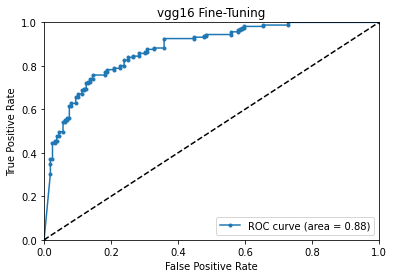

In [19]:
# ROC Curves and AUC
plt.plot(fpr,tpr ,marker='.', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('vgg16 Fine-Tuning')
plt.legend(loc="lower right")
plt.savefig('vgg16 Fine-Tuning.png')

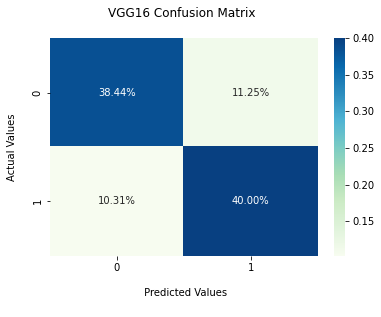

In [26]:
cf_matrix = confusion_matrix(y_test.round(), y_prob[:,1].round())
fx = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='GnBu')
fx.set_title('VGG16 Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');

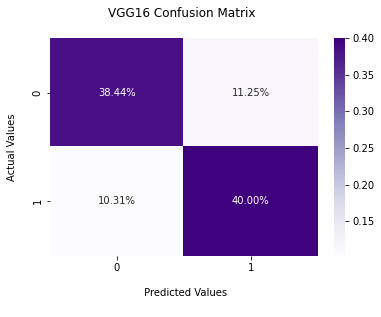

In [27]:
cf_matrix = confusion_matrix(y_test.round(), y_prob[:,1].round())
fx = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Purples')
fx.set_title('VGG16 Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');

In [28]:
accuracy = accuracy_score(y_test,y_pred,normalize = True)
accuracy

0.784375

In [29]:
f1 = f1_score(y_test, y_pred)
f1

0.7876923076923077